In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error # squared=True 기본
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
from tqdm import tqdm
import shutil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

In [3]:
train = pd.read_csv('train/train.csv')
print(train.shape)
train.tail(1)

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52559,1094,23,30,0,0,2.1,67.7,-4,0.0


해당 시간은 포함 한 버전

In [86]:
train_df = [train.iloc[i:(i+289),:][['TARGET']].T.values.tolist()[0] for i in tqdm(range((train.shape[0]-289+1)))]
train_df = pd.DataFrame(train_df)
target1 = train.iloc[48*7:,:][['TARGET']].reset_index(drop=True) 
target2 = train.iloc[48*8:,:][['TARGET']].reset_index(drop=True)
print(train_df.shape, target1.shape, target2.shape)
train_df = pd.concat([train_df.iloc[:target2.shape[0]], target1.iloc[:target2.shape[0]], target2],axis=1).reset_index(drop=True)
train_df.columns = ['{}'.format(j) for j in range(289)] + ['target1','target2']
print(train_df.shape)
train_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████| 52272/52272 [00:32<00:00, 1617.32it/s]


(52272, 289) (52224, 1) (52176, 1)
(52176, 291)


,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,target1,target2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

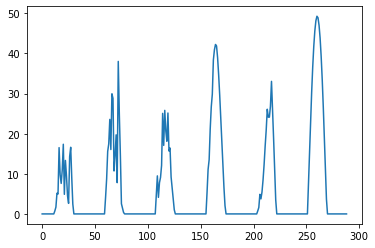

In [73]:
sns.lineplot(x=[j for j in range(289)],y=list(train_df.iloc[100,:-2]))

<AxesSubplot:>

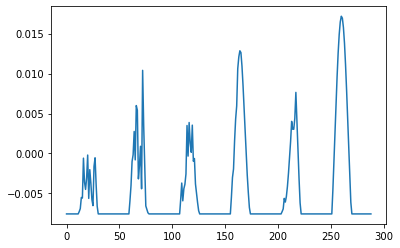

In [85]:
a = list(train_df.iloc[100,:-2])
b = np.exp((np.array(a)+0.001) / np.max(train.TARGET)) 
c = (b - np.exp(np.mean(train.TARGET)/ np.max(train.TARGET))) / np.std(train.TARGET)
sns.lineplot(x=[j for j in range(289)],y=c)

In [50]:
train_df = [train.iloc[i:(i+289),:][['TARGET']].T.values.tolist()[0] for i in tqdm(range((train.shape[0]-289+1)))]
avg_T_df = [np.mean(train.iloc[i:(i+289),:][['T']].T.values.tolist()[0]) for i in tqdm(range((train.shape[0]-289+1)))]
avg_WS_df = [np.mean(train.iloc[i:(i+289),:][['WS']].T.values[0]) for i in tqdm(range((train.shape[0]-289+1)))]
time_label_df = [i for i in range(48)]*1096

train_df = pd.DataFrame(train_df) ; avg_T_df = pd.DataFrame(avg_T_df) ; avg_WS_df = pd.DataFrame(avg_WS_df); time_label_df = pd.DataFrame(time_label_df)  
target1 = train.iloc[48*7:,:][['TARGET']].reset_index(drop=True) 
target2 = train.iloc[48*8:,:][['TARGET']].reset_index(drop=True)
print(train_df.shape, target1.shape, target2.shape)
train_df = pd.concat([train_df.iloc[:target2.shape[0]],avg_T_df.iloc[:target2.shape[0]],avg_WS_df.iloc[:target2.shape[0]],
                      time_label_df.iloc[:target2.shape[0]], target1.iloc[:target2.shape[0]], target2],axis=1).reset_index(drop=True)
train_df.columns = ['{}'.format(j) for j in range(289)] + ['avg_T','avg_WS','time_label'] + ['target1','target2']
print(train_df.shape)
train_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████| 52272/52272 [00:31<00:00, 1656.81it/s]


(52272, 289) (52224, 1) (52176, 1)
(52176, 294)


,0,1,2,3,4,5,6,7,8,9,...,284,285,286,287,288,avg_T,avg_WS,time_label,target1,target2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-3.826990,2.484083,0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-3.792388,2.485121,1,0.0,0.0


In [105]:
s = np.array(train_df.iloc[train_index,:-2]).flatten().std()
m = np.array(train_df.iloc[train_index,:-2]).flatten().mean()
s,m

(25.810484645839463, 17.853856123588315)

---

### Train 시키기 

In [8]:
def make_id(i):
    id_ls = []
    for day in [7,8]:
        for hour in range(0,24):
            for minute in ['00','30']:
                id_ls.append('{}.csv_Day{}_{}h{}m'.format(i,day,hour,minute))
    return id_ls

def test_predict(i,df,date):
    result = pd.DataFrame({'id':make_id(i)})
    model1_pred = pd.DataFrame()
    model2_pred = pd.DataFrame()
    
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for q in quantiles:
        model1 = joblib.load('model/{}/model1/q{}'.format(date, str(q).replace('.','')))
        model2 = joblib.load('model/{}/model2/q{}'.format(date, str(q).replace('.','')))
        pred1 = pd.Series(model1.predict(df).round(6))
        pred2 = pd.Series(model2.predict(df).round(6))
        model1_pred = pd.concat([model1_pred,pred1],axis=1)
        model2_pred = pd.concat([model2_pred,pred2],axis=1)
    predict_df = pd.concat([model1_pred,model2_pred],axis=0).reset_index(drop=True)
    
    result = pd.concat([result,predict_df],axis=1)
    result.columns = ['id','q_0.1','q_0.2','q_0.3','q_0.4','q_0.5','q_0.6','q_0.7','q_0.8','q_0.9']
        
    return result

In [9]:
def train_real(date, train_x1, valid_x1, train_y1, valid_y1, train_x2, valid_x2, train_y2, valid_y2):
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    if not os.path.isdir('model/{}'.format(date)):
        os.makedirs('model/{}/model1'.format(date), exist_ok=True)
        os.makedirs('model/{}/model2'.format(date), exist_ok=True)
    
    for q in tqdm(quantiles):
        model1, error1 = LGBM(q, train_x1, train_y1, valid_x1, valid_y1)
        joblib.dump(model1,'model/{}/model1/q{}'.format(date,str(q).replace('.','')))

        model2, error2 = LGBM(q, train_x2, train_y2, valid_x2, valid_y2)
        joblib.dump(model2,'model/{}/model2/q{}'.format(date, str(q).replace('.','')))

In [10]:
def train_quantiles(train_x1, valid_x1, train_y1, valid_y1, train_x2, valid_x2, train_y2, valid_y2):
    error_dict1 = {} ; error_dict2 = {}
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    for q in tqdm(quantiles):
        model1, error1 = LGBM(q, train_x1, train_y1, valid_x1, valid_y1)
        error_dict1['q{}'.format(str(q).replace('.',''))] = error1

        model2, error2 = LGBM(q, train_x2, train_y2, valid_x2, valid_y2)
        error_dict2['q{}'.format(str(q).replace('.',''))] = error2
    return error_dict1, error_dict2

---

**0109_2.csv 버전의 parameter setting**: 
- (1) only TARGET(6일치) 해당 시간은 포함 한 버전 (EX. Day0 00:00 ~ 6Day 00:00 → 7Day 00:00 & 8Day 00:00)
    - **validation result (learning_rate=0.27):** 1.9851580591408864 2.0597448131375735
    - **validation result (learning_rate=0.35):** 1.9847158419201467 2.0585949337218543
    - **real result:** 1.8954564652
    - iterations
        - model1: [ 470.4, 2033.8, 2956.8, 4742.6, 2728.2, 2592. , 1787. , 1530.8, 726.2]
        - model2: [ 589.8, 1416.8, 2994.2, 4300. , 1602. , 2574.2, 1702.4, 1465.4, 798. ]
- (2) TARGET(6일치) 해당 시간은 포함 한 버전 + 평균 온도 + 평균 풍속 + time labeling
    - **validation result:** 1.922229391509244 1.9679833640958935
    - **real result:** 1.9102602405


In [87]:
train_x1, valid_x1, train_y1, valid_y1 = train_test_split(train_df.iloc[:,:-2], train_df.iloc[:,-2], test_size=0.2, random_state=42)
train_x2, valid_x2, train_y2, valid_y2 = train_test_split(train_df.iloc[:,:-2], train_df.iloc[:,-1], test_size=0.2, random_state=42)

In [88]:
def LGBM(q, train_x, train_y, valid_x, valid_y):
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.035, subsample=0.7)
    model.fit(train_x, train_y, eval_metric = ['quantile'], 
          eval_set=[(valid_x, valid_y)], early_stopping_rounds=300, verbose=False)
    min_error = min(model.evals_result_['valid_0']['quantile'])
    iter_num = len(model.evals_result_['valid_0']['quantile']) - 300 # early_stopping_rounds=300
    return model, min_error, iter_num

In [89]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

error_dict1 = {} ; error_dict2 = {} ; num_dict1 = {} ; num_dict2 = {}
for i, (train_index, valid_index) in tqdm(enumerate(cv.split(train_df)), total=5):
    train_x, valid_x = train_df.iloc[train_index,:-2],train_df.iloc[valid_index,:-2]
    train_y1, valid_y1 = train_df.iloc[train_index,-2], train_df.iloc[valid_index,-2] # model1
    train_y2, valid_y2 = train_df.iloc[train_index,-1], train_df.iloc[valid_index,-1] # model2
    
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for q in quantiles:
        model1, error1, num1 = LGBM(q, train_x, train_y1, valid_x, valid_y1)
        model2, error2, num2 = LGBM(q, train_x, train_y2, valid_x, valid_y2)

        if i == 0:
            error_dict1['q{}'.format(str(q).replace('.',''))] = [error1]
            error_dict2['q{}'.format(str(q).replace('.',''))] = [error2]
            num_dict1['q{}'.format(str(q).replace('.',''))] = [num1]
            num_dict2['q{}'.format(str(q).replace('.',''))] = [num2]
        else:
            error_dict1['q{}'.format(str(q).replace('.',''))].append(error1)
            error_dict2['q{}'.format(str(q).replace('.',''))].append(error2)    
            num_dict1['q{}'.format(str(q).replace('.',''))].append(num1)
            num_dict2['q{}'.format(str(q).replace('.',''))].append(num2)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [28:45<00:00, 345.15s/it]


In [90]:
print(np.mean(list(error_dict1.values())), np.mean(list(error_dict2.values())), np.mean(list(num_dict1.values())), np.mean(list(num_dict2.values())))

1.9847158419201467 2.0585949337218543 2187.1555555555556 2371.6666666666665


In [93]:
np.mean(list(num_dict1.values()),axis=1), np.mean(list(num_dict2.values()),axis=1)

(array([ 563.2, 1733. , 3041.6, 4145.2, 4033.6, 2957.8, 1415.4, 1224.2,
         570.4]),
 array([ 400.6, 1280.2, 2053.4, 5256.8, 4016.8, 4336.4, 1914.8, 1468.6,
         617.4]))

---

**단순히 7일치의 연속 데이터를 이용하여 바로 다음 시간의 전력량 예측하는 모델**
  - EX. 0Day 00:00 ~ 6Day 23:30 → 7Day 00:00
  - 얘를 이용해서 test에서 예측값을 사용하면 어떨까

In [21]:
train_df = [train.iloc[i:(i+336),:][['TARGET']].T.values.tolist()[0] for i in tqdm(range((train.shape[0]-336+1)))]
train_df = pd.DataFrame(train_df)
target = train.iloc[48*7:,:][['TARGET']].reset_index(drop=True) 
print(train_df.shape, target.shape)
train_df = pd.concat([train_df.iloc[:target.shape[0]], target],axis=1).reset_index(drop=True)
train_df.columns = ['{}'.format(j) for j in range(336)] + ['target']
print(train_df.shape)
train_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████| 52225/52225 [00:31<00:00, 1646.92it/s]


(52225, 336) (52224, 1)
(52224, 337)


,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
train_x1, valid_x1, train_y1, valid_y1 = train_test_split(train_df.iloc[:,:-1], train_df.iloc[:,-1], test_size=0.2, random_state=42)

In [37]:
def LGBM(train_x, train_y, valid_x, valid_y):
    model = LGBMRegressor(objective='rmse', n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)
    model.fit(train_x, train_y, eval_metric = ['rmse'], 
          eval_set=[(valid_x, valid_y)], early_stopping_rounds=300, verbose=False)
    min_error = min(model.evals_result_['valid_0']['rmse'])
    return model, min_error

In [38]:
model, min_error = LGBM(train_x1, train_y1, valid_x1, valid_y1)
print(min_error)

7.288462843915198


In [39]:
def LGBM(train_x, train_y, valid_x, valid_y):
    model = LGBMRegressor(objective='rmse', n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)
    model.fit(train_x, train_y, eval_metric = ['rmse'], 
          eval_set=[(valid_x, valid_y)], early_stopping_rounds=300, verbose=False)
    min_error = min(model.evals_result_['valid_0']['rmse'])
    iter_num = len(model.evals_result_['valid_0']['rmse']) - 300 # early_stopping_rounds=300
    return model, min_error, iter_num

In [42]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

error_ls = [] ; num_ls = []
for i, (train_index, valid_index) in tqdm(enumerate(cv.split(train_df)), total=5):
    train_x, valid_x = train_df.iloc[train_index,:-1],train_df.iloc[valid_index,:-1]
    train_y1, valid_y1 = train_df.iloc[train_index,-1], train_df.iloc[valid_index,-1] 
    
    model, error, num = LGBM(train_x, train_y1, valid_x, valid_y1)
    error_ls.append(error)
    num_ls.append(num)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.85s/it]


In [43]:
print(np.mean(error_ls,), np.mean(num_ls))

7.250035072290236 254.0


In [48]:
def LGBM(train_x, train_y, valid_x, valid_y):
    model = LGBMRegressor(objective='rmse', n_estimators=10000, bagging_fraction=0.7, learning_rate=0.035, subsample=0.7)
    model.fit(train_x, train_y, eval_metric = ['rmse'], 
          eval_set=[(valid_x, valid_y)], early_stopping_rounds=300, verbose=False)
    min_error = min(model.evals_result_['valid_0']['rmse'])
    iter_num = len(model.evals_result_['valid_0']['rmse']) - 300 # early_stopping_rounds=300
    return model, min_error, iter_num

cv = KFold(n_splits=5, shuffle=True, random_state=42)

error_ls = [] ; num_ls = []
for i, (train_index, valid_index) in tqdm(enumerate(cv.split(train_df)), total=5):
    train_x, valid_x = train_df.iloc[train_index,:-1],train_df.iloc[valid_index,:-1]
    train_y1, valid_y1 = train_df.iloc[train_index,-1], train_df.iloc[valid_index,-1] 
    
    model, error, num = LGBM(train_x, train_y1, valid_x, valid_y1)
    error_ls.append(error)
    num_ls.append(num)
print(np.mean(error_ls,), np.mean(num_ls))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.13s/it]

7.23891435166062 188.4


---

### Test 및 submission (1) : 80%의 training data만 사용하는 경우

#### data 

In [84]:
train_x1, valid_x1, train_y1, valid_y1 = train_test_split(train_df.iloc[:,:-2], train_df.iloc[:,-2], test_size=0.2, random_state=42)
train_x2, valid_x2, train_y2, valid_y2 = train_test_split(train_df.iloc[:,:-2], train_df.iloc[:,-1], test_size=0.2, random_state=42)

#### Model 및 Training

In [85]:
def LGBM(q, train_x, train_y, valid_x, valid_y):
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)
    model.fit(train_x, train_y, eval_metric = ['quantile'], eval_set=[(valid_x, valid_y)], 
              early_stopping_rounds=300, verbose=False)
    min_error = min(model.evals_result_['valid_0']['quantile'])
    return model, min_error

In [86]:
def train_real(date, train_x1, valid_x1, train_y1, valid_y1, train_x2, valid_x2, train_y2, valid_y2):
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    if not os.path.isdir('model/{}'.format(date)):
        os.makedirs('model/{}/model1'.format(date), exist_ok=True)
        os.makedirs('model/{}/model2'.format(date), exist_ok=True)
    
    for q in tqdm(quantiles):
        model1, error1 = LGBM(q, train_x1, train_y1, valid_x1, valid_y1)
        joblib.dump(model1,'model/{}/model1/q{}'.format(date,str(q).replace('.','')))

        model2, error2 = LGBM(q, train_x2, train_y2, valid_x2, valid_y2)
        joblib.dump(model2,'model/{}/model2/q{}'.format(date, str(q).replace('.','')))

In [87]:
train_real('0114_2',train_x1, valid_x1, train_y1, valid_y1, train_x2, valid_x2, train_y2, valid_y2)




  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7





 11%|█████████▎                                                                          | 1/9 [00:19<02:38, 19.86s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:46<02:46, 23.80s/it]


 33%|████████████████████████████                                                        | 3/9 [02:15<05:22, 53.82s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [04:29<07:07, 85.42s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [05:14<04:42, 70.73s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [06:23<03:30, 70.05s/it]


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [07:32<02:19, 69.73s/it]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [08:20<01:02, 62.96s/it]


100%|████████████████

#### Test data 및 submission 생성

In [92]:
dfs = []
for i in tqdm(range(81)):
    path = 'test/{}.csv'.format(i)
    df = pd.read_csv(path)
    test_df = pd.DataFrame([df.iloc[i:(i+289),:][['TARGET']].T.values.tolist()[0] for i in range((df.shape[0]-288))]) # df.shape[0]-288
    
    avg_T_df = pd.DataFrame([np.mean(df.iloc[i:(i+289),:][['T']].T.values.tolist()[0]) for i in tqdm(range((df.shape[0]-288)))])
    avg_WS_df = pd.DataFrame([np.mean(df.iloc[i:(i+289),:][['WS']].T.values[0]) for i in tqdm(range((df.shape[0]-288)))])
    time_label_df = pd.DataFrame([i for i in range(48)])
    test_df = pd.concat([test_df,avg_T_df,avg_WS_df,time_label_df], axis=1)
    test_df.columns = ['{}'.format(j) for j in range(289)] + ['avg_T','avg_WS','time_label']
    
    predict_result = test_predict(i,test_df,'0114_2')
    dfs.append(predict_result)
sub = pd.concat(dfs,axis=0).reset_index(drop=True)
print(sub.shape)




  0%|                                                                                           | 0/81 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1659.63it/s]




100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1659.62it/s]



  1%|█                                                                                  | 1/81 [00:01<02:20,  1.76s/it]



100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1203.19it/s]




100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1718.92it/s]



  2%|██                                                                                 | 2/81 [00:03<02:16,  1.73s/it]



100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1203.20it/s]




100%|█████

(7776, 10)


In [93]:
sub.to_csv('submission/{}.csv'.format('0114_2') , index=False)